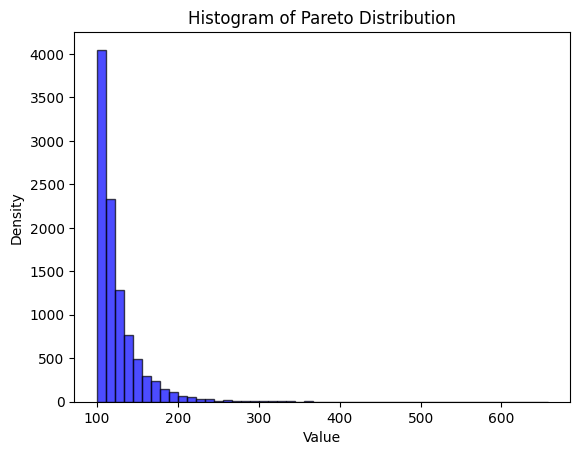

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def pareto(alpha, m, size=1000):
    """Generate random samples from a Pareto distribution."""
    u = np.random.rand(size)
    samples = m / np.power(u, 1.0/alpha)
    return samples

# Parameters for Pareto distribution
alpha = 5  # Shape parameter
m = 100.0  # Scale parameter

# Generate Pareto distributed samples
samples = pareto(alpha, m, size=10000)

# Plotting the histogram
plt.hist(samples, bins=50, density=False, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Pareto Distribution')

# Show plot
plt.show()


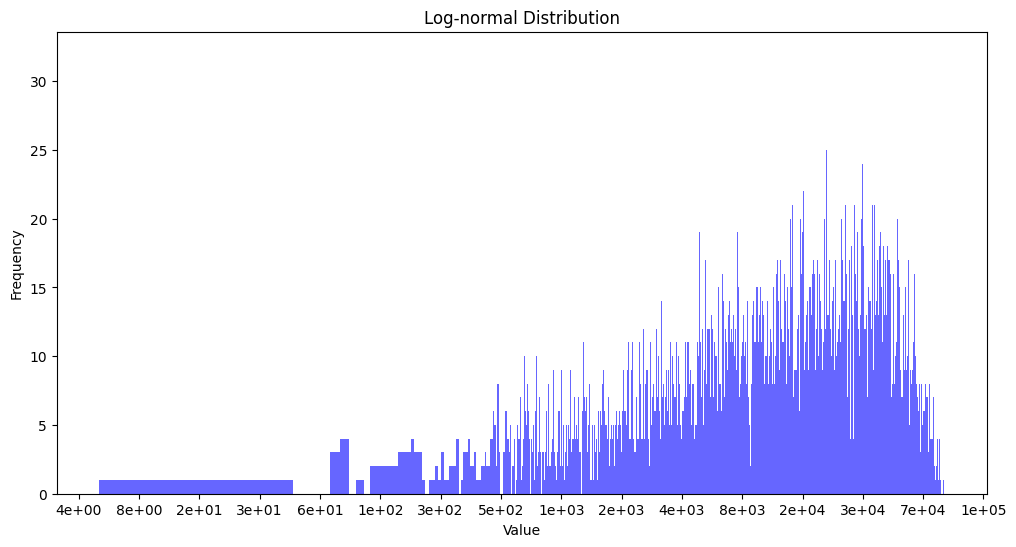

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FormatStrFormatter

# 设置随机种子以确保可重复性
np.random.seed(42)

# 生成对数正态分布的数据
mu = 3     # 对数正态分布的均值（对数刻度）
sigma = 1  # 对数正态分布的标准差（对数刻度）
# s = np.random.lognormal(mu, sigma, 1000)
alpha, beta = 1.5, 2
s = np.random.beta(alpha, beta, 100000) * 168 * 500


# 绘制统计直方图
plt.figure(figsize=(12, 6))
count, bins, ignored = plt.hist(s, bins=10000, density=False, alpha=0.6, color='b')

# # 为了对比，在同一图上绘制对数正态分布的概率密度函数（PDF）
# x = np.linspace(min(s), max(s), 10000)
# pdf = (np.exp(-(np.log(x) - mu) ** 2 / (2 * sigma ** 2))
#        / (x * sigma * np.sqrt(2 * np.pi)))
# plt.plot(x, pdf, linewidth=2, color='r')

# # 设置对数刻度
plt.xscale('log')
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(base=2.0, numticks=100))
ax.xaxis.set_minor_locator(LogLocator(base=2.0, subs='auto', numticks=100))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.e'))

# 设置图表标题和标签
plt.title('Log-normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [115]:
ss = [sss*12 for sss in s if sss>=500]
count, bins, ignored = plt.hist(ss, bins=5000, density=False, alpha=0.6, color='b')
plt.xscale('log')

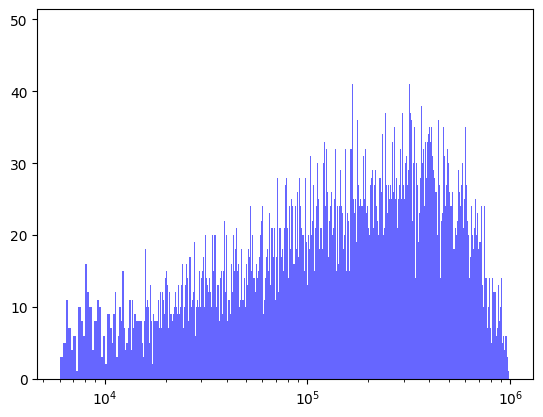

In [116]:
count, bins, ignored = plt.hist(ss, bins=5000, density=False, alpha=0.6, color='b')
plt.xscale('log')

In [1]:
from utils import beta_dist

[1.0848554  1.0766936  1.30679079 1.04433821 1.00552396 1.03578304
 2.21900343 1.13360808 1.06479214 3.3329926 ]


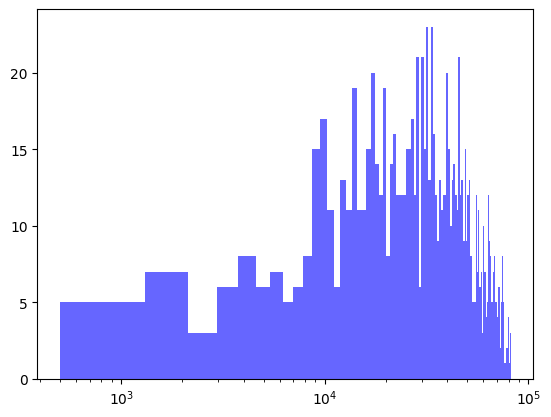

In [11]:
s = []
for i in range(1000):
    s.append(beta_dist()[0])
count, bins, ignored = plt.hist(s, bins=100, density=False, alpha=0.6, color='b')
plt.xscale('log')

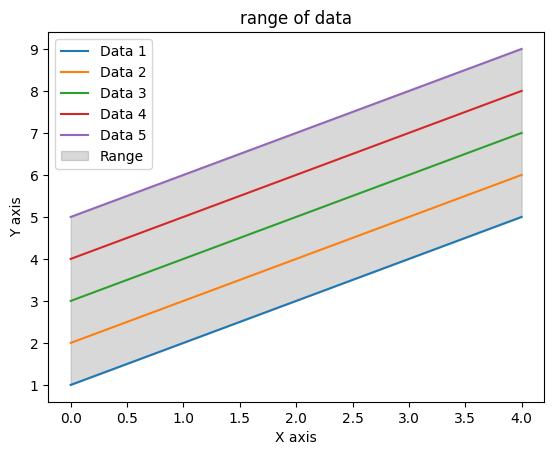

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 假设这是您通过实验得到的五个列表
data1 = [1, 2, 3, 4, 5]
data2 = [2, 3, 4, 5, 6]
data3 = [3, 4, 5, 6, 7]
data4 = [4, 5, 6, 7, 8]
data5 = [5, 6, 7, 8, 9]

# X轴的数据，这里假设是等间隔的整数
x = np.arange(len(data1))

# 计算每个X值对应的所有列表中的最小值和最大值
y_min = [min(data1[i], data2[i], data3[i], data4[i], data5[i]) for i in range(len(data1))]
y_max = [max(data1[i], data2[i], data3[i], data4[i], data5[i]) for i in range(len(data1))]

# 创建一个新的图形
plt.figure()

# 绘制每个列表的线图
plt.plot(x, data1, label='Data 1')
plt.plot(x, data2, label='Data 2')
plt.plot(x, data3, label='Data 3')
plt.plot(x, data4, label='Data 4')
plt.plot(x, data5, label='Data 5')

# 填充波动范围的阴影
plt.fill_between(x, y_min, y_max, color='gray', alpha=0.3, label='Range')

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('range of data')
plt.xlabel('X axis')
plt.ylabel('Y axis')

# 显示图形
plt.show()
